---
title: "Classical vs. Heuristic Optimisation: Comparing MILP, Genetic Algorithms and Simulated Annealing for Pumped Storage Hydropower Optimisation"
author: "Mathias Steilen"
date: "20/09/2024"
abstract: "I implement the genetic algorithm and simulated annealing to optimise the operation of a pumped storage system in the day-ahead market. How do they compare with the solution found by classical mixed-integer linear programming? Let's find out."
categories:
  - Optimisation
  - Python
  - Energy Economics
image: image.jpg
draft: false
execute:
  echo: true
  freeze: auto
format:
  html:
    embed-resources: true
    toc: true
    toc-expand: 2
    toc-title: Table of contents
    number-sections: false
    number-depth: 3
    number-offset:
      - 0
      - 0
    smooth-scroll: true
    page-layout: full
    code-fold: show
    code-overflow: scroll
    highlight-style: github
---

![](image.jpg)

<style>
body {
text-align: justify}
</style>

Let's start off by loading the required packages for this blog post:

In [18]:
# Data processing
import numpy as np
import pandas as pd
import polars as pl

# Optimisation
from pulp import (
    LpMaximize,
    LpMinimize,
    LpProblem,
    LpStatus,
    lpSum,
    LpVariable,
    LpContinuous,
    LpInteger,
    value
)


# Visualisation
import plotnine as pn
import plotly.express as px
from IPython.display import display, clear_output
from mizani.formatters import comma_format, percent_format
import imageio

# Hyperparameter tuning
import optuna
import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# Utils
import os
from tqdm.notebook import tqdm
import json
from itertools import product
import warnings

# Options
background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
    )
)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


# TLDR

If you're short on time, here's the essence: The advantages of heuristic (meaning: including trial and error) optimisation methods is that they can deal with highly complex optimisation problem involving non-linear objective functions and still find a decent solution where classical optimisation might fail to find the optimal one. The goal of this blog post is to benchmark these methods on a problem which is quite easy to solve using linear programming, i.e. one of the classical approaches. What will be the price to pay when using heuristics instead? Or in other words: How good are the local optima found by the heuristic optimisation methods?

As shown in the GIF below, neither the genetic algorithm (GA), nor simulated annealing (SA) were able to find the optimal solution (350k of profit), but they came very close with 339k (GA) and 317k (SA). The computing time allowed for both (also for random search) was 30 seconds. The best solution found my random search/brute force was -127k. Given the simplicity of the heuristic algorithms, I really find this result amazing and I am positively surprised by how well they did.

<img src="./04 - Animation/final_animation.gif" width=500>


# Problem Stting: The Pumped Storage Hydropower Plant

The problem we are looking at is optimising a pumped storage hydropower (PSH) plant in the day-ahead. Now what does that mean?

PSH plants can have all shapes and sizes, but in their most basic constellation, they consist of

- an upper water reservoir,
- a low water reservoir,
- a pump and
- a turbine.

We can characterise these four major parts with their corresponding parameters, which will define the "physics" of our optimisation problem. Of course, you can make these arbitrarily difficult, but for this demonstration, let's stick with the easiest one with an upper reservoir and lower reservoir of the same sizes.

<img src="PSH plant.png" width=400>

In [19]:
plant_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
plant_params["INITIAL_WATER_LEVEL"] = (
    plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
)
plant_params["PUMP_RATE_M3H"] = (
    plant_params["TURBINE_RATE_M3H"] * plant_params["EFFICIENCY"]
)
plant_params["MAX_STORAGE_MWH"] = (
    plant_params["MAX_STORAGE_M3"] / plant_params["TURBINE_RATE_M3H"]
) * plant_params["TURBINE_POWER_MW"]

plant_params

{'EFFICIENCY': 0.75,
 'MAX_STORAGE_M3': 5000,
 'MIN_STORAGE_M3': 0,
 'TURBINE_POWER_MW': 100,
 'PUMP_POWER_MW': 100,
 'TURBINE_RATE_M3H': 500,
 'MIN_STORAGE_MWH': 0,
 'INITIAL_WATER_LEVEL_PCT': 0,
 'INITIAL_WATER_LEVEL': 0,
 'PUMP_RATE_M3H': 375.0,
 'MAX_STORAGE_MWH': 1000.0}

Having defined the physical layout of our PSH plant (in Python code above), we can now look at what we could actually do with this. In theory and practice, PSH acts like a giant battery that stores energy by using the gravitational potential energy of water. "Charging" this hydro-battery is done by activating the pump and transporting water from the lower to the upper reservoir. Discharging works the other way around, by funnelling the water through the turbines down into the lower reservoir. Now of course, there are energy losses in a round trip, but most PSH efficiencies lie between 70%-80%.

Having a giant battery at your disposal enables you to do energy arbitrage, that is buying energy at low prices and selling at high prices. This is visualised below: There are 9 hours, each of which has a price at which the PSH system can decide between three options:

- Pump
- Do Nothing
- Turbine

For instance, one schedule could look like this: [N, N, N, P, P, P, P, T, T, T]. In this scenario, the PSH would do nothing for 3 hours, pump the next 4 and turbine the last 3 hours. The system would pay the price of the four hours (in EUR/MWh) times the energy used by the pump (in MWH) and receive the opposite for the times it turbined. Therefore, the revenue received by the system is:

$$dt_i * P_{Turbine} * Spot_i + dp_i * P_{Pump} * Spot_i$$


where $dt_i$ and $dp_i$ represent dummy variables for the actions of turbining or pumping and the index $i$ denotes the hour for which these decisions were made. This forms the basis of our objective function we want to maximise. Having a system that was expensive to build, we want to run it optimally to maximise the revenues by its operation. You might be thinking: Always receiving money would maximise this function, so why don't we just always turbine? And this question leads to our constraints: The limits of the reservoirs need to be respected. If the upper reservoir is full (empty), you can't continue to pump (turbine).

<img src="sketch.png" width=500>

## Data

I will select one week's worth of day-ahead spot price data, which will be the horizon to be optimised. In order to keep the focus on optimisation, I will assume we have perfect foresight and know the prices perfectly in advance. This is of course not the case in practice and you would have the additional uncertainty in your forecasts, which lends to the usefulness of stochastic optimisation methods like stochastic dynamic programming.

In [20]:
prices = (
    pl.read_csv("01 - Data/spot_prices_utc.csv")
    .with_columns(pl.col("utc_time").str.to_datetime(), pl.col("spot").forward_fill())
    .drop_nulls()
)

window_size = 24*7

example = prices.filter(
    pl.col("utc_time") >= pd.to_datetime("2022-01-01").tz_localize("UTC")
).head(window_size)

example.head()


spot,utc_time
f64,"datetime[μs, UTC]"
101.54,2022-01-01 00:00:00 UTC
52.13,2022-01-01 01:00:00 UTC
20.78,2022-01-01 02:00:00 UTC
15.66,2022-01-01 03:00:00 UTC
21.47,2022-01-01 04:00:00 UTC


For this example week, we have 168 hours of prices:

In [21]:
example.shape

(168, 2)

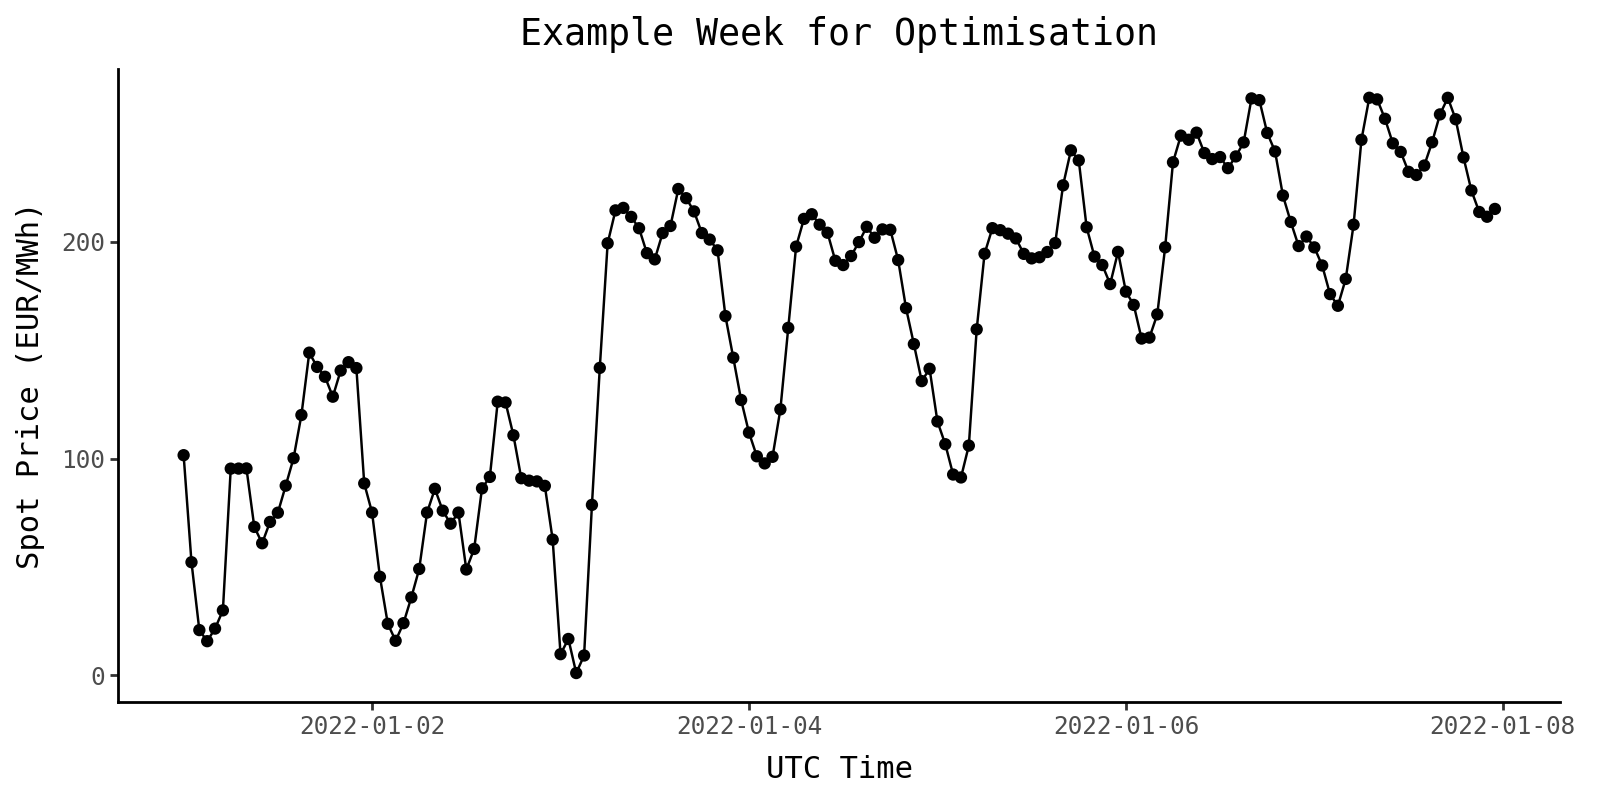

In [22]:
(
    pn.ggplot(data=example,
              mapping=pn.aes("utc_time", "spot"))
    + pn.geom_line()
    + pn.geom_point()
    + pn.labs(title="Example Week for Optimisation", y="Spot Price (EUR/MWh)", x="UTC Time")
    + pn.theme(figure_size=[8, 4])
)

This setting is very short compared to PSH optimisation in practice where the horizon might be one or multiple years. However, the size of the search space is not negligible. Assuming you have 3 options every hour, the number of available schedules would be $3^{168}$, which is larger than the number of atoms in the universe. Searching through all of these different schedules via brute-force is already computationally impossible. This makes the use of heuristic algorithms exciting, as they also rely on random search via trial and error.

# Genetic Algorithm

A genetic algorithm relies on the concept of natural selection. Initialising a population of candidate solutions, each candidate is evaluated based on a fitness function, and the best-performing ones are selected to produce the next generation. The next generation is generated by crossing over (combining) the best individuals from the previous generations and mutating these new candidates (random changes). For this application, these are the main steps:

- Initialisation: The algorithm starts with a population of random individuals. Each individual contains the randomly chosen initial [pump, do nothing, turbine] dummies. This leads to an array of $n_{individuals} \times n_{hours}$.
 
- Evaluation: Each individual is then evaluated based on how well it solves the problem. This is called the fitness score. In this example, the goal is to maximise the revenue by the PSH which was explained above.
 
- Selection: Knowing how well each individual did, those with better fitness scores (for example the upper half) are then selected to reproduce and create the next generation (elitism).
 
- Reproduction: The selected individuals (parents) are used create offspring for the next generation. Parent parameters are combined to create new individuals. Additionally, mutation is randomly applied (slightly changing some individuals’ parameters) to create changes in the offspring to prevent the population from narrowing in on a particular area too much.
 
- Termination: The process continues until a satisfactory solution is found. In this example, I allowed the genetic algorithm to run for around 30 seconds, which I will keep consistent for simulated annealing and brute force as well to be comparable.

## Fitness Function

As mentioned above, the fitness function evaluates how well each invididual performs. If you remember, the ideal case without constraints would be to turbine at every step. As we have lake limits and limited water though, this behaviour needs to be discouraged and made impossible. I simply introduced a large penalty every time the lake levels are disrespected.

In [23]:
def evaluate_fitness(population, ps_params, prices):

    # To be written according to pumped storage optimisation problem
    fitness_scores = np.array([])

    for parameter_combination in population:

        water_level = ps_params["INITIAL_WATER_LEVEL"]
        fitness_score = 0

        for action, price in zip(parameter_combination, prices["spot"]):
            # Pump (-1)
            if action == -1:
                if (
                    water_level + ps_params["PUMP_RATE_M3H"]
                    <= ps_params["MAX_STORAGE_M3"]
                ):
                    fitness_score -= ps_params["PUMP_POWER_MW"] * price
                    water_level += ps_params["PUMP_RATE_M3H"]
                else:
                    fitness_score -= 100_000
            # Turbine (1)
            if action == 1:
                if (
                    water_level - ps_params["TURBINE_RATE_M3H"]
                    >= ps_params["MIN_STORAGE_M3"]
                ):
                    fitness_score += ps_params["TURBINE_POWER_MW"] * price
                    water_level -= ps_params["TURBINE_RATE_M3H"]
                else:
                    fitness_score -= 100_000
            # Do nothing (0)
            # Nothing happens to the fitness score and the water level

        fitness_scores = np.append(fitness_scores, fitness_score)

    return fitness_scores

## The Algorithm

Now the implementation of the algorithm itself has a few details (like mutation rate decay, survival rates etc.) which I will not describe in detail in order to keep this halfway interesting. If you are interested in the details of the implementation, please feel free to reach out!

What is interesting to know is that for the implementation, pretty much the only thing you need are numpy arrays, which are just glorified lists or matrices. It was really astounding to me, how you could make something so powerful out of such simple tools like randomly combining and changing solutions.

In [40]:
class GA_discrete_actions:

    def __init__(
        self,
        dna_size,
        discrete_action_space,
        elitism=0.25,
        survival_rate=0.25,
        population_size=200,
        initial_mutation_rate=0.1,
        final_mutation_rate=0.01,
        total_generations=100
    ):

        self.dna_size = dna_size
        self.discrete_action_space = discrete_action_space
        self.elitism = elitism
        self.survival_rate = survival_rate
        self.population_size = population_size
        self.elite_size = int(self.elitism * self.population_size)
        self.initial_mutation_rate = initial_mutation_rate
        self.mutation_rate = initial_mutation_rate
        self.final_mutation_rate = final_mutation_rate
        self.total_generations = total_generations
        
        self.best_dna = None
        self.best_fitness = None
        self.average_fitness = None

        self.initial_population = self.__create_random_population()

    def evolve(self, population, fitnesses):

        assert len(population) == self.population_size
        assert len(fitnesses) == len(population)
        assert isinstance(population, np.ndarray)

        # Sort population and fitnesses
        fitness_indices = fitnesses.argsort()
        sorted_fitnesses = fitnesses[fitness_indices]
        sorted_population = population[fitness_indices]

        # Report the best fitness and parameters
        self.best_dna = sorted_population[-1]
        self.best_fitness = sorted_fitnesses[-1]
        self.average_fitness = np.mean(sorted_fitnesses)

        # Only keep the elite of the population and get their weighting
        elite = sorted_population[-self.elite_size :]
        sorted_elite_fitnesses = sorted_fitnesses[-self.elite_size :]

        # Calculate weighting for elite
        min_fitness = sorted_elite_fitnesses.min()
        max_fitness = sorted_elite_fitnesses.max()

        if min_fitness == max_fitness:
            # If all fitnesses are equal, set weighting to uniform distribution
            fitnesses_weighting = np.full_like(
                sorted_elite_fitnesses, 1 / len(sorted_elite_fitnesses), dtype=np.float32
            )
        else:
            fitnesses_weighting = (sorted_elite_fitnesses - min_fitness) / (
                max_fitness - min_fitness
            )
            fitnesses_weighting /= fitnesses_weighting.sum()

        new_population = np.zeros((self.population_size, self.dna_size))

        # Keep the population according to survival rate
        survival_cutoff = int(np.floor(self.survival_rate * self.population_size))
        new_population[0:survival_cutoff] = sorted_population[-survival_cutoff:]

        # Crossover the elite only, rest of population doesn't cross over
        for child_id in np.arange(survival_cutoff + 1, self.population_size):
            i0 = np.random.choice(
                a=self.elite_size, p=fitnesses_weighting, replace=True
            )
            i1 = np.random.choice(
                a=self.elite_size, p=fitnesses_weighting, replace=True
            )

            new_dna = self.__crossover(elite[i0], elite[i1])
            
            assert isinstance(new_dna, np.ndarray)

            new_population[child_id] = new_dna

        # Mutate the new population
        for dna_id in range(self.population_size):
            new_population[dna_id] = self.__mutate(new_population[dna_id])

        # Adjust mutation rate: linear decay dependent on total generations
        self.mutation_rate = self.mutation_rate - 1/self.total_generations * (self.initial_mutation_rate - self.final_mutation_rate)
        self.mutation_rate = np.maximum(self.mutation_rate, self.final_mutation_rate)

        assert new_population.shape == self.initial_population.shape

        return new_population

    def __create_random_population(self):
        population = np.random.choice(
            a=self.discrete_action_space, size=(self.population_size, self.dna_size)
        )
        return population

    def __mutate(self, dna):

        # If random dice roll (between zero and one) is less than mutation
        # rate (between zero and one) then inject noise into the dna.
        if np.random.random_sample() < self.mutation_rate:
            # Randomly select which element to mutate and insert random integer parameters
            position = np.random.choice(a=np.arange(0, len(dna)), size=1)
            new_options = [x for x in self.discrete_action_space if x != dna[position]]
            mutation_value = np.random.choice(a=new_options, size=1)
            dna[position] = mutation_value

        return dna

    def __crossover(self, dna1, dna2):
        assert len(dna1) == len(dna2)
        # set child's DNA to be of the first parent
        child = np.copy(dna1)
        # replace random positions with dna from second parent
        dna2_indices = np.random.randint(2, size=child.size)
        indices = np.where(dna2_indices)
        child[indices] = dna2[indices]

        return child

Now, as you can see below, there are a lot of hyperparameters that can be set and tweaked:

In [41]:
ga = GA_discrete_actions(
    dna_size=window_size,
    discrete_action_space=[-1, 0, 1],
    elitism=0.2,
    population_size=100,
    survival_rate=0.25,
    initial_mutation_rate=0.1,
    final_mutation_rate=0.01,
    total_generations=100
)

In [42]:
np.random.seed(42)
population = ga.initial_population
average_fitnesses = []
best_fitnesses = []

for generation in (pbar := tqdm(range(ga.total_generations))):

    population = ga.evolve(
        population=population,
        fitnesses=evaluate_fitness(
            population=population, ps_params=plant_params, prices=example
        ),
    )
    average_fitnesses.append(ga.average_fitness)
    best_fitnesses.append(ga.best_fitness)

    pbar.set_description(f"Best fitness: {best_fitnesses[-1]}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
ga.best_fitness

0.0

With these randomly set parameters, the genetic algorithm already achieved a positive result! The resulting solution can be seen in the numpy array below:

In [44]:
ga.best_dna

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

From this, we can construct a dataframe for later visualisation:

In [45]:
best_profile = (
    example.to_pandas().assign(
        action=ga.best_dna,
        colour_id=lambda x: np.select(
            [x.action == -1, x.action == 0, x.action == 1],
            ["pump", "nothing", "turbine"],
        ),
        water_level=lambda x: plant_params["INITIAL_WATER_LEVEL_PCT"] * plant_params["MAX_STORAGE_M3"]
        + np.select(
            [x.action == 1, x.action == -1],
            [plant_params["PUMP_RATE_M3H"], -plant_params["TURBINE_RATE_M3H"]],
            0,
        ).cumsum(),
    )
)

best_profile.head()

,spot,utc_time,action,colour_id,water_level
0,101.540,2022-01-01 00:00:00+00:00,0.000,nothing,0.000
1,52.130,2022-01-01 01:00:00+00:00,0.000,nothing,0.000
2,20.780,2022-01-01 02:00:00+00:00,0.000,nothing,0.000
3,15.660,2022-01-01 03:00:00+00:00,0.000,nothing,0.000
4,21.470,2022-01-01 04:00:00+00:00,0.000,nothing,0.000


## Tuning Hyperparameters

In order to find good hyperparameters, I wanted to use something smarter than grid or random search and chose Optuna, a hyperparameter optimisation framework, to adjust key parameters of the genetic algorithm. To do so, you need to define the search space for the hyperparameters like elitism, population size, survival rate, and mutation rate. Optuna then runs the genetic algorithm I implemented with these parameters and sequentially searches in promising areas of the hyperparameter space. I allocated 1 hour of search time for finding good hyperparameters for the genetic algorithm. Note that I only allowed a runtime of 100 generations per trial, which is less than the 30 seconds I plan to allocate for the final run with optimised hyperparameters.

In [46]:
def genetic_algorithm_tuning(trial):

    config = {
        "dna_size": window_size,
        "discrete_action_space": [-1, 0, 1],
        "elitism": trial.suggest_float("elitism", 0.1, 0.9),
        "population_size": trial.suggest_categorical("population_size", [50, 100, 500, 1000]),
        "survival_rate": trial.suggest_float("survival_rate", 0.1, 0.9),
        "initial_mutation_rate": trial.suggest_float("initial_mutation_rate", 0.2, 1),
        "final_mutation_rate": 0.01,
        "total_generations": 100,
    }

    ga = GA_discrete_actions(**config)

    population = ga.initial_population

    for _ in range(config["total_generations"]):
        population = ga.evolve(
            population=population,
            fitnesses=evaluate_fitness(
                population=population, ps_params=plant_params, prices=example
            ),
        )

    return ga.best_fitness

In [ ]:
#| eval: false
np.random.seed(42)

study = optuna.create_study(direction='maximize')
study.optimize(genetic_algorithm_tuning, n_trials=1e4, timeout=60*60)

In [17]:
#| eval: false
study.best_params

In [18]:
#| eval: false
with open("02 - Tuning Results/ga_tuning_params.json", "w") as outfile: 
    json.dump(study.best_params, outfile)

## Final Run


After tuning the hyperparameters, I am loading the best ones and let the genetic algorithm run for 30 seconds with this hyperparameters configuration.

In [47]:
with open("02 - Tuning Results/ga_tuning_params.json") as infile: 
    ga_params = json.load(infile)

In [48]:
# | eval: false
np.random.seed(42)
ga = GA_discrete_actions(
    dna_size=window_size,
    discrete_action_space=[-1, 0, 1],
    elitism=ga_params["elitism"],
    population_size=ga_params["population_size"],
    survival_rate=ga_params["survival_rate"],
    initial_mutation_rate=ga_params["initial_mutation_rate"],
    final_mutation_rate=0.1,
    total_generations=250,
)

population = ga.initial_population
params_best = None
fitness_best = None
average_fitnesses = []
best_fitnesses = []
best_solutions = []
all_fitnesses = []

for generation in (pbar := tqdm(range(ga.total_generations))):
    fitnesses = evaluate_fitness(
        population=population, ps_params=plant_params, prices=example
    )
    population = ga.evolve(
        population=population,
        fitnesses=fitnesses,
    )

    # Store historically best solution
    if params_best is None or ga.best_fitness > fitness_best:
        params_best = ga.best_dna
        fitness_best = ga.best_fitness

    # Store all solutions for animation
    best_solutions.append(ga.best_dna)
    all_fitnesses.append(fitnesses)

    # Store history for visualisation
    average_fitnesses.append(ga.average_fitness)
    best_fitnesses.append(fitness_best)

    pbar.set_description(f"Best fitness: {best_fitnesses[-1]:.0f}")

  0%|          | 0/250 [00:00<?, ?it/s]

The currently best fitness in the population is:

In [49]:
# | eval: false
ga.best_fitness

339890.0

The best fitness found over the 250 generations is:

In [50]:
# | eval: false
fitness_best

339890.0

It is incredibly interesting to see how the population (10% of the population shown below) converges to its solution. It seems like the solutions form subpopulations which are rather stable over time. For the algorithm this is likely a bad thing, as higher genetic diversity should lead to better results.

<img src="ga_fitnesses.gif" width=500>

Let's store that solution for later visualisation and comparison with the other algorithms:

In [23]:
# | eval: false
actions = example.with_columns(ga_action = pl.Series(params_best))

actions.head()

In [24]:
# | eval: false
actions.to_pandas().to_csv("./03 - Final Run Results/actions.csv", index=False)

In [25]:
# | eval: false
with open('03 - Final Run Results/ga_actions.npy', 'wb') as f:
    np.save(f, np.array(best_solutions))

with open('03 - Final Run Results/ga_best_fitnesses.npy', 'wb') as f:
    np.save(f, np.array(best_fitnesses))

with open('03 - Final Run Results/ga_all_fitnesses.npy', 'wb') as f:
    np.save(f, np.array(all_fitnesses))

# Simulated Annealing

Now let's move over to simulated annealing (SA). The latter is inspired by the annealing process in metallurgy, where materials are heated and then slowly cooled to reach a stable, low-energy state. In the optimisation framework here, the idea is to explore the solution space by accepting both better and slightly worse solutions initially to avoid getting stuck in local optima. Then, after some time, you want to gradually focus on improving the solution as the algorithm "cools down." and reduce the chances of accepting a worse solution. By this logic, you will hopefully have found a region where the local optimum is close to optimal.

- Initialisation: The algorithm starts with a random solution, which in this case is a sequence of [pump, do nothing, turbine] actions across the time horizon (hours), just like the GA.

- Evaluation: The current solution is evaluated using the energy function, which like the GA aims to maximize revenue from the PSH operation. 

- Exploration: A new solution is generated by making small changes to the current solution (mutating some actions). This new solution is evaluated, and if it improves the fitness, it is accepted. However, if the new solution is worse, it can still be accepted with a certain probability. This probability decreases over time, allowing the algorithm to explore a wide range of solutions in the beginning and then narrow its focus on better solutions as it progresses.

- Termination: The process continues until a stopping condition is met, either when the temperature is sufficiently low, or a set time limit is reached. In my case, I allowed simulated annealing to run for around 30 seconds, the same time limit used for the genetic algorithm and brute force methods to ensure comparability.

## The Energy Function

Conveniently, the energy function takes the exact same function as the fitness function in the genetic algorithm. However this time, we want to minimise energy. Therefore, I wrote a function for profit (including the penalties) and I minimised the negative of that.

In [52]:
def profit(actions, ps_params, prices):
    water_level = ps_params["INITIAL_WATER_LEVEL"]
    profit = 0

    for action, price in zip(actions, prices["spot"]):
        # Pump (-1)
        if action == -1:
            if (
                (water_level + ps_params["PUMP_RATE_M3H"])
                <= ps_params["MAX_STORAGE_M3"]
            ):
                profit -= ps_params["PUMP_POWER_MW"] * price
                water_level += ps_params["PUMP_RATE_M3H"]
            else:
                profit -= 1e5
        # Turbine (1)
        if action == 1:
            if (
                (water_level - ps_params["TURBINE_RATE_M3H"])
                >= ps_params["MIN_STORAGE_M3"]
            ):
                profit += ps_params["TURBINE_POWER_MW"] * price
                water_level -= ps_params["TURBINE_RATE_M3H"]
            else:
                profit -= 1e5
    
    return profit

## Tuning Hyperparameters

The hyperparameter tuning works exactly the same, however I am using RayTune now, which also allows for Optuna search, but simultaneously parallelises on your system. I had a strange error with RayTune for the GA, therefore I used Optuna before.

In [29]:
def simulated_annealing(config, tune_mode=False):
    
    params = np.random.choice([-1,0,1], size=example.shape[0])
    params_best = None
    energy_best = None

    for i in (pbar := tqdm(range(config["iterations"]))):
        
        # Linear temperature decay (easier to scale to larger number of iterations later)
        temperature = config["initial_temp"] - i/config["iterations"] * config["initial_temp"]

        # Generate random neighbour by randomly flipping actions
        params_new = params.copy()
        for _ in range(config["flip_size"]):
            idx = np.random.choice(np.arange(0, len(params)))
            new_options = [x for x in [-1,0,1] if x != params[idx]]
            params_new[idx] = np.random.choice(new_options)
            
        # Calculate energy for old and new state
        energy_old = -profit(actions=params, prices=example, ps_params=plant_params)
        energy_new = -profit(actions=params_new, prices=example, ps_params=plant_params)
        if energy_best is None:
            params_best = params
            energy_best = energy_old
                
        # Calculate acceptance probability
        # If solution is better than previous accept immediately
        if energy_new < energy_old:
            # Solution is better than previous, but is it better than best
            if energy_new < energy_best:
                params_best = params_new.copy()
                energy_best = energy_new
            params = params_new.copy()
        # If solution isn't better than previous, accept maybe
        else:
            acceptance_prob = np.exp(-(energy_new - energy_old)/(temperature + 1e-8))
            if np.random.uniform() < acceptance_prob:
                params = params_new.copy()

        if tune_mode:
            train.report({"energy": energy_best})
        else:
            pbar.set_description(f"Profit: {-energy_best:.2f}")

    if not tune_mode:
        return params_best

In [30]:
#| eval: false

# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    tune.with_parameters(
        simulated_annealing,
        tune_mode=True,
    ),
    config={
        "iterations": 1000,
        "initial_temp": tune.uniform(0.01, 10),
        "flip_size": tune.randint(1, 50),
    },
    metric="energy",
    mode="min",
    local_dir="tune_results",
    name="SA",
    search_alg=OptunaSearch(),
    time_budget_s=60*60,
    num_samples=-1,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

In [31]:
#| eval: false
f"Best Profit: {-analysis.best_result['energy']:.2f}"

In [32]:
#| eval: false
top_runs = analysis.dataframe().sort_values("energy", ascending=True).head(10)["trial_id"].to_list()

fig = px.line(
    data_frame=pd.concat(analysis.trial_dataframes.values()).query(
        "trial_id in @top_runs"
    ),
    x="training_iteration",
    y="energy",
    color="trial_id",
)
fig.show()

In [33]:
#| eval: false
analysis.best_config

In [34]:
#| eval: false
with open("02 - Tuning Results/sa_tuning_params.json", "w") as outfile: 
    json.dump(analysis.best_config, outfile)

## Final Run

Like before, let's increase the number of iterations such that we reach around 30 seconds of run time and proceed with a final run:

In [56]:
with open("02 - Tuning Results/sa_tuning_params.json") as infile: 
    sa_params = json.load(infile)
old_sa_params = sa_params.copy()
old_sa_params

{'iterations': 1000, 'initial_temp': 7.629941060448957, 'flip_size': 2}

I am increasing the initial temperature proportionately with the increase in iterations in order to finish on the same temperature as in the best tuning run.

In [57]:
sa_params["iterations"] = 75_000
sa_params["initial_temp"] *= sa_params["iterations"] / old_sa_params["iterations"]

sa_params

{'iterations': 75000, 'initial_temp': 572.2455795336717, 'flip_size': 2}

In [58]:
#| eval: false
np.random.seed(42)
params = np.random.choice([-1,0,1], size=example.shape[0])
params_best = None
energy_best = None
best_profits = []
best_solutions = []
all_profits = []


for i in (pbar := tqdm(range(sa_params["iterations"]))):
    
    # Modify temperature parameters
    # temperature = initial_temp/(i + 1)
    temperature = sa_params["initial_temp"] - i/sa_params["iterations"] * sa_params["initial_temp"]

    # Generate random neighbour by randomly flipping actions
    params_new = params.copy()
    for _ in range(sa_params["flip_size"]):
        idx = np.random.choice(np.arange(0, len(params)))
        new_options = [x for x in [-1,0,1] if x != params[idx]]
        params_new[idx] = np.random.choice(new_options)
        
    # Calculate energy for old and new state
    energy_old = -profit(actions=params, prices=example, ps_params=plant_params)
    all_profits.append(-energy_old)
    energy_new = -profit(actions=params_new, prices=example, ps_params=plant_params)
    if energy_best is None:
        params_best = params
        energy_best = energy_old
            
    # Calculate acceptance probability
    # If solution is better than previous accept immediately
    if energy_new < energy_old:
        # Solution is better than previous, but is it better than best
        if energy_new < energy_best:
            params_best = params_new.copy()
            energy_best = energy_new
        params = params_new.copy()
    # If solution isn't better than previous, accept maybe
    else:
        acceptance_prob = np.exp(-(energy_new - energy_old)/(temperature + 1e-8))
        if np.random.uniform() < acceptance_prob:
            params = params_new.copy()

    # Save interim results
    best_solutions.append(params_best)
    best_profits.append(-energy_best)
    

    pbar.set_description(f"Profit: {-energy_best:,.0f} Temperature: {temperature:,.2f}")

  0%|          | 0/75000 [00:00<?, ?it/s]

In [59]:
# | eval: false
profit(actions=params, prices=example, ps_params=plant_params)

317164.0

In [39]:
# | eval: false
actions = (
    pl.read_csv("./03 - Final Run Results/actions.csv", try_parse_dates=True)
    .select("utc_time", "spot", "ga_action")
    .with_columns(pl.col("ga_action").cast(pl.Int64))
    .with_columns(sa_action = pl.Series(params).cast(pl.Int64))
)
actions.to_pandas().to_csv("./03 - Final Run Results/actions.csv", index=False)
actions.head()

In [40]:
# | eval: false
with open('03 - Final Run Results/sa_actions.npy', 'wb') as f:
    np.save(f, np.array(best_solutions))

with open('03 - Final Run Results/sa_best_profits.npy', 'wb') as f:
    np.save(f, np.array(best_profits))

with open('03 - Final Run Results/sa_all_profits.npy', 'wb') as f:
    np.save(f, np.array(all_profits))

# Brute Force Search

There is not much to be said in this section other than: In order to have a benchmark to see how well the algorithms perform, let's use a "naive" brute force search that just tries out random things and saves the best result:

In [60]:
# | eval: false
np.random.seed(42)
params_best = None
profit_best = None
best_profits = []
best_solutions = []


for i in (pbar := tqdm(range(150_000))):

    # Generate random candidate
    params = np.random.choice(a=[-1, 0, 1], size=example.shape[0])

    # Calculate profit
    current_profit = profit(actions=params, prices=example, ps_params=plant_params)

    # Check if it's historically best
    if profit_best is None or current_profit > profit_best:
        params_best = params.copy()
        profit_best = current_profit

    # Save interim results
    best_solutions.append(params_best)
    best_profits.append(profit_best)

    pbar.set_description(f"Profit: {profit_best:.2f}")

  0%|          | 0/150000 [00:00<?, ?it/s]

In [61]:
profit_best

-127094.0

The best profit found by random search is still very much negative and nowhere near the two heuristic algorithms.

In [62]:
# | eval: false
actions = ( 
    pl.read_csv("./03 - Final Run Results/actions.csv", try_parse_dates=True)
    .select("utc_time", "spot", "ga_action", "sa_action")
    .with_columns(pl.col("ga_action").cast(pl.Int64))
    .with_columns(pl.col("sa_action").cast(pl.Int64))
    .with_columns(bf_action = pl.Series(params_best).cast(pl.Int64))
)
actions.to_pandas().to_csv("./03 - Final Run Results/actions.csv", index=False)
actions.head()

utc_time,spot,ga_action,sa_action,bf_action
"datetime[μs, UTC]",f64,i64,i64,i64
2022-01-01 00:00:00 UTC,101.54,0,0,-1
2022-01-01 01:00:00 UTC,52.13,-1,-1,0
2022-01-01 02:00:00 UTC,20.78,-1,-1,-1
2022-01-01 03:00:00 UTC,15.66,-1,-1,0
2022-01-01 04:00:00 UTC,21.47,-1,-1,1


In [63]:
# | eval: false
with open('03 - Final Run Results/bf_actions.npy', 'wb') as f:
    np.save(f, np.array(best_solutions))

with open('03 - Final Run Results/bf_best_profits.npy', 'wb') as f:
    np.save(f, np.array(best_profits))

# Mixed Integer Linear Programming

Now, this is where things get interesting, as we can use classical optimisation methods such as mixed integer linear programming for this problem to find the actual optimal schedule. Again, the objective is to maximise revenue. I defined binary decision variables for pumping and turbine usage for each time step, ensuring that both actions cannot occur simultaneously. I also modeled water level dynamics as a state variable, updating it based on the chosen actions (pumping or generating electricity) while ensuring that it stays within predefined boundaries. You do not have to work with penalties for this method, as you can set mathematical constraints directly. The objective function calculates the revenue from electricity generation, adjusted by the cost of pumping, considering the spot prices. Finally, I added constraints for water storage limits and solved the model to find the optimal sequence of actions.

In [64]:
# Create names for decision variables
dec_vars = range(example.shape[0])

# The cost/revenue associated with each decision variable is the
# spot price
spot = dict(zip(dec_vars, example["spot"].to_list()))

# Decision variables
dp = LpVariable.dicts("pump_dummy", dec_vars, 0, 1, cat="Binary")
dt = LpVariable.dicts("turbine_dummy", dec_vars, 0, 1, cat="Binary")

# State Variables
water_level = LpVariable.dict(
    "water_level",
    dec_vars,
    plant_params["MIN_STORAGE_M3"],
    plant_params["MAX_STORAGE_M3"],
    cat="Continuous",
)

# Initialise Model
model = LpProblem(name="pumped_storage_optimisation", sense=LpMaximize)

# Add objective function
model += (
    lpSum(
        [
            dt[i] * plant_params["TURBINE_POWER_MW"] * example["spot"][i]
            - dp[i] * plant_params["PUMP_POWER_MW"] * example["spot"][i]
            for i in dec_vars
        ]
    ),
    "revenue",
)

# Add constraints
for i in dec_vars:
    # Don't pump and turbine at the same time
    model += (dt[i] + dp[i] <= 1, f"no_simultaneous_pump_and_turbine_upper_{i}")
    model += (dt[i] + dp[i] >= 0, f"no_simultaneous_pump_and_turbine_lower_{i}")

    # Add constraint to update water level
    if i == 0:
        model += (
            water_level[i]
            == plant_params["INITIAL_WATER_LEVEL"]
            + dp[i] * plant_params["PUMP_RATE_M3H"]
            - dt[i] * plant_params["TURBINE_RATE_M3H"],
            f"initial_water_level_{i}",
        )
    else:
        # Update water level based on previous level, pumping, and turbine action
        model += (
            water_level[i]
            == water_level[i - 1]
            + dp[i] * plant_params["PUMP_RATE_M3H"]
            - dt[i] * plant_params["TURBINE_RATE_M3H"],
            f"water_level_update_{i}",
        )

    # Add constraints for water level boundaries
    model += (water_level[i] <= plant_params["MAX_STORAGE_M3"], f"max_storage_{i}")
    model += (water_level[i] >= plant_params["MIN_STORAGE_M3"], f"min_storage_{i}")


# Solve the model
model.solve()

1

In [65]:
LpStatus[model.status]

'Optimal'

In [66]:
model.objective.value()

350291.0

Interestingly, none of the heuristic algorithms managed to hit the optimum, but they managed to get close.

In [68]:
# | eval: false
best_profile = (
    pd.DataFrame(
        {
            "variable": [v.name for v in model.variables()],
            "value": [v.value() for v in model.variables()],
        }
    )
    .assign(
        name=lambda x: x["variable"].apply(lambda r: r.rsplit("_", 1)[0]),
        hour=lambda x: x["variable"].apply(lambda r: r.rsplit("_", 1)[1]).astype(int),
    )
    .drop("variable", axis=1)
    .pivot(index="hour", columns="name", values="value")
    .reset_index()
    .rename_axis(None, axis=1)
    .sort_values("hour")
    .assign(
        action=lambda x: np.select(
            condlist=[
                x["pump_dummy"] == 1,
                x["turbine_dummy"] == 1,
            ],
            choicelist=[
                -1,
                1,
            ],
            default=0,
        ),
        colour_id=lambda x: np.select(
            condlist=[
                x["pump_dummy"] == 1,
                x["turbine_dummy"] == 1,
            ],
            choicelist=[
                "pump",
                "turbine",
            ],
            default="nothing",
        ),
        utc_time=pd.to_datetime(example["utc_time"]),
        spot=example["spot"].to_list(),
    )
    .drop(["pump_dummy", "turbine_dummy", "hour"], axis=1)
)

In [69]:
# | eval: false
actions = (
    pl.read_csv("./03 - Final Run Results/actions.csv", try_parse_dates=True)
    .select("utc_time", "spot", "ga_action", "sa_action", "bf_action")
    .with_columns(pl.col("ga_action").cast(pl.Int64))
    .with_columns(pl.col("sa_action").cast(pl.Int64))
    .with_columns(pl.col("bf_action").cast(pl.Int64))
    .with_columns(milp_action = pl.Series(best_profile["action"]).cast(pl.Int64))
)
actions.to_pandas().to_csv("./03 - Final Run Results/actions.csv", index=False)
actions.head()

utc_time,spot,ga_action,sa_action,bf_action,milp_action
"datetime[μs, UTC]",f64,i64,i64,i64,i64
2022-01-01 00:00:00 UTC,101.54,0,0,-1,0
2022-01-01 01:00:00 UTC,52.13,-1,-1,0,-1
2022-01-01 02:00:00 UTC,20.78,-1,-1,-1,-1
2022-01-01 03:00:00 UTC,15.66,-1,-1,0,-1
2022-01-01 04:00:00 UTC,21.47,-1,-1,1,-1


# Conclusion

Having implemented, tuned, ran and stored all of the above methods, let's compare their final performance in this section:

In [71]:
actions = (
    pl.read_csv("./03 - Final Run Results/actions.csv", try_parse_dates=True)
    .with_columns(
        pl.col("ga_action").cast(pl.Int64),
        pl.col("sa_action").cast(pl.Int64),
        pl.col("bf_action").cast(pl.Int64),
        pl.col("milp_action").cast(pl.Int64),
    )
)
actions.head()

utc_time,spot,ga_action,sa_action,bf_action,milp_action
"datetime[μs, UTC]",f64,i64,i64,i64,i64
2022-01-01 00:00:00 UTC,101.54,0,0,-1,0
2022-01-01 01:00:00 UTC,52.13,-1,-1,0,-1
2022-01-01 02:00:00 UTC,20.78,-1,-1,-1,-1
2022-01-01 03:00:00 UTC,15.66,-1,-1,0,-1
2022-01-01 04:00:00 UTC,21.47,-1,-1,1,-1


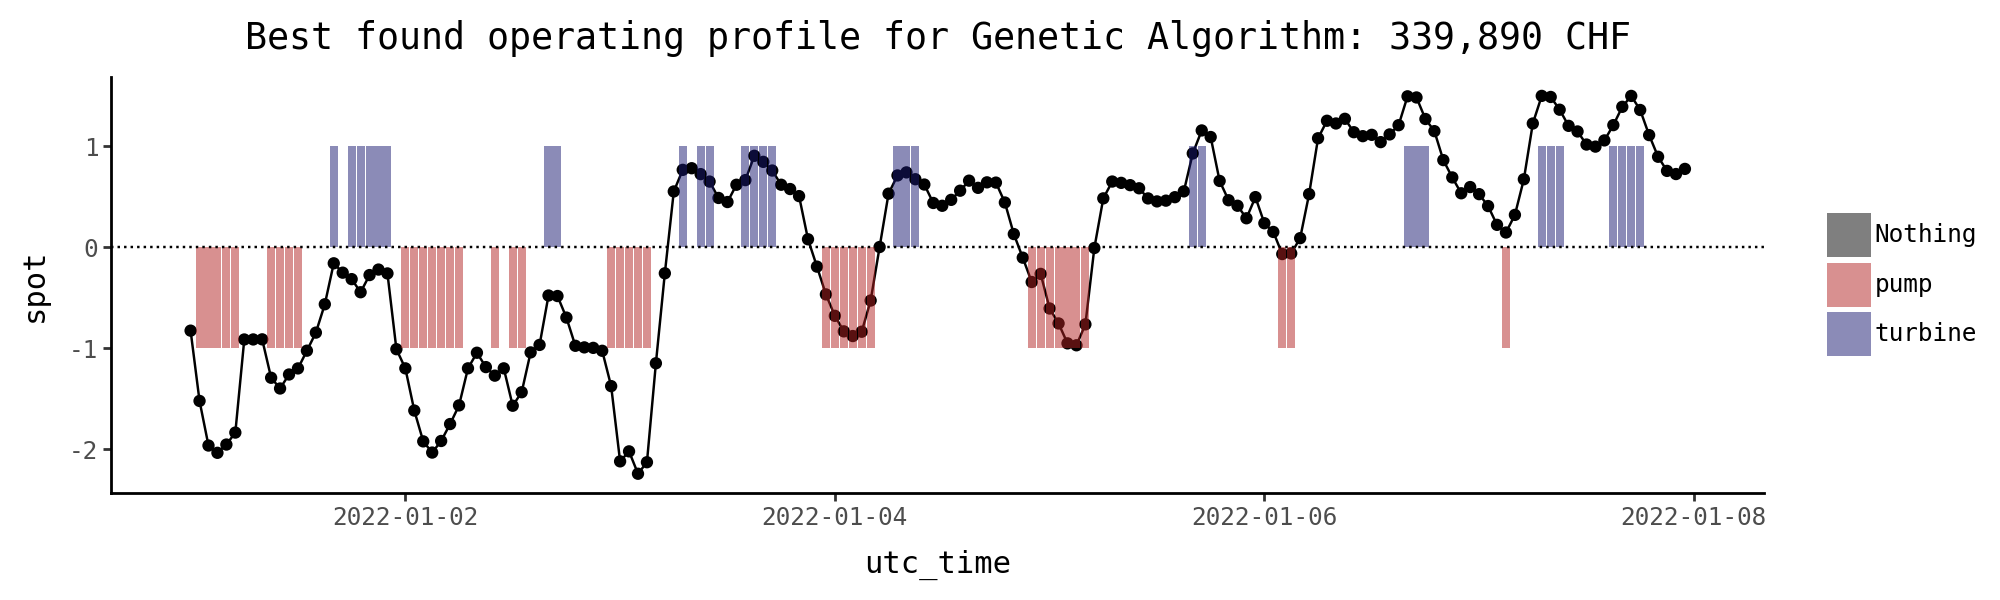

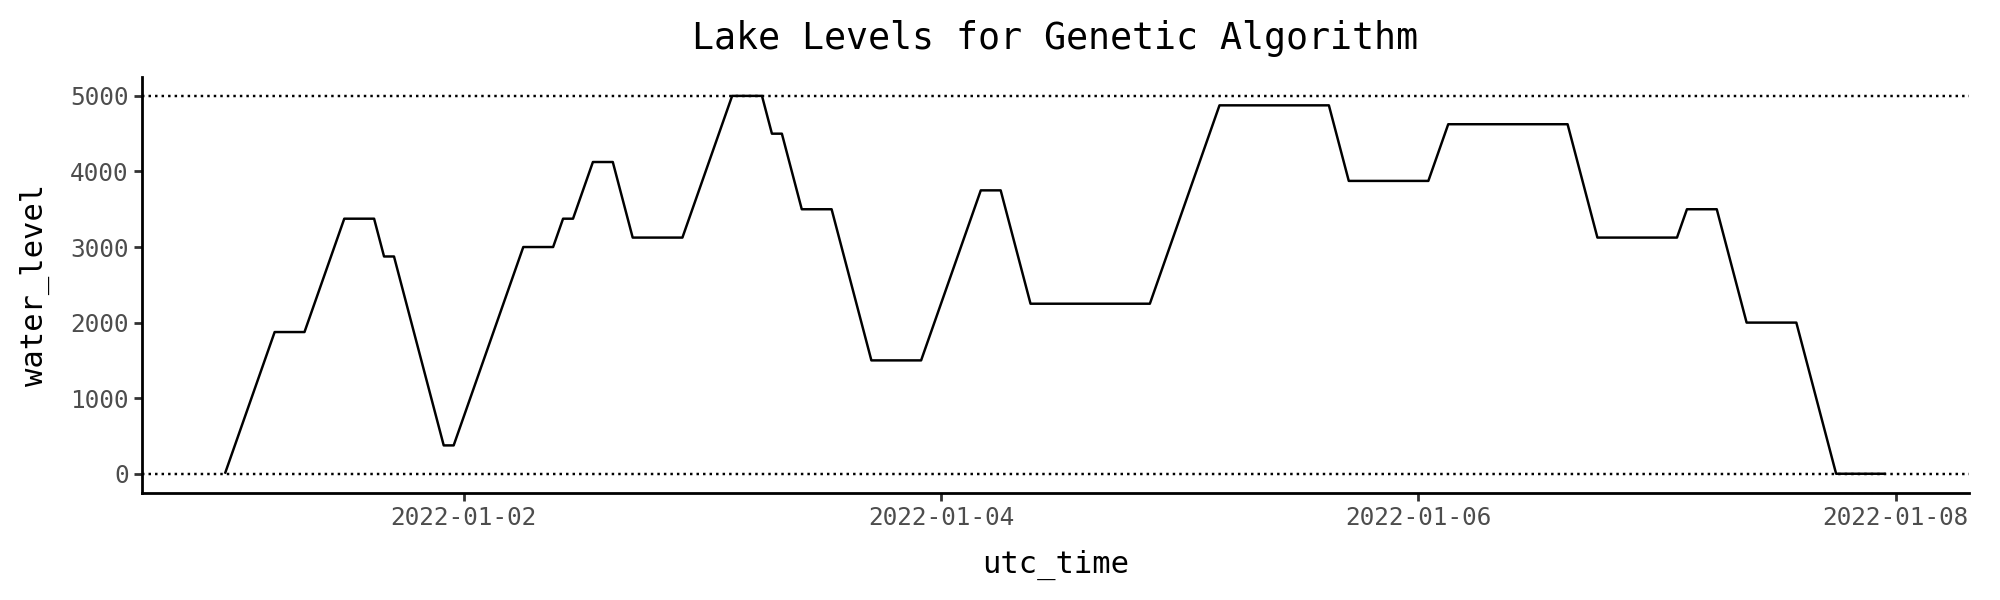

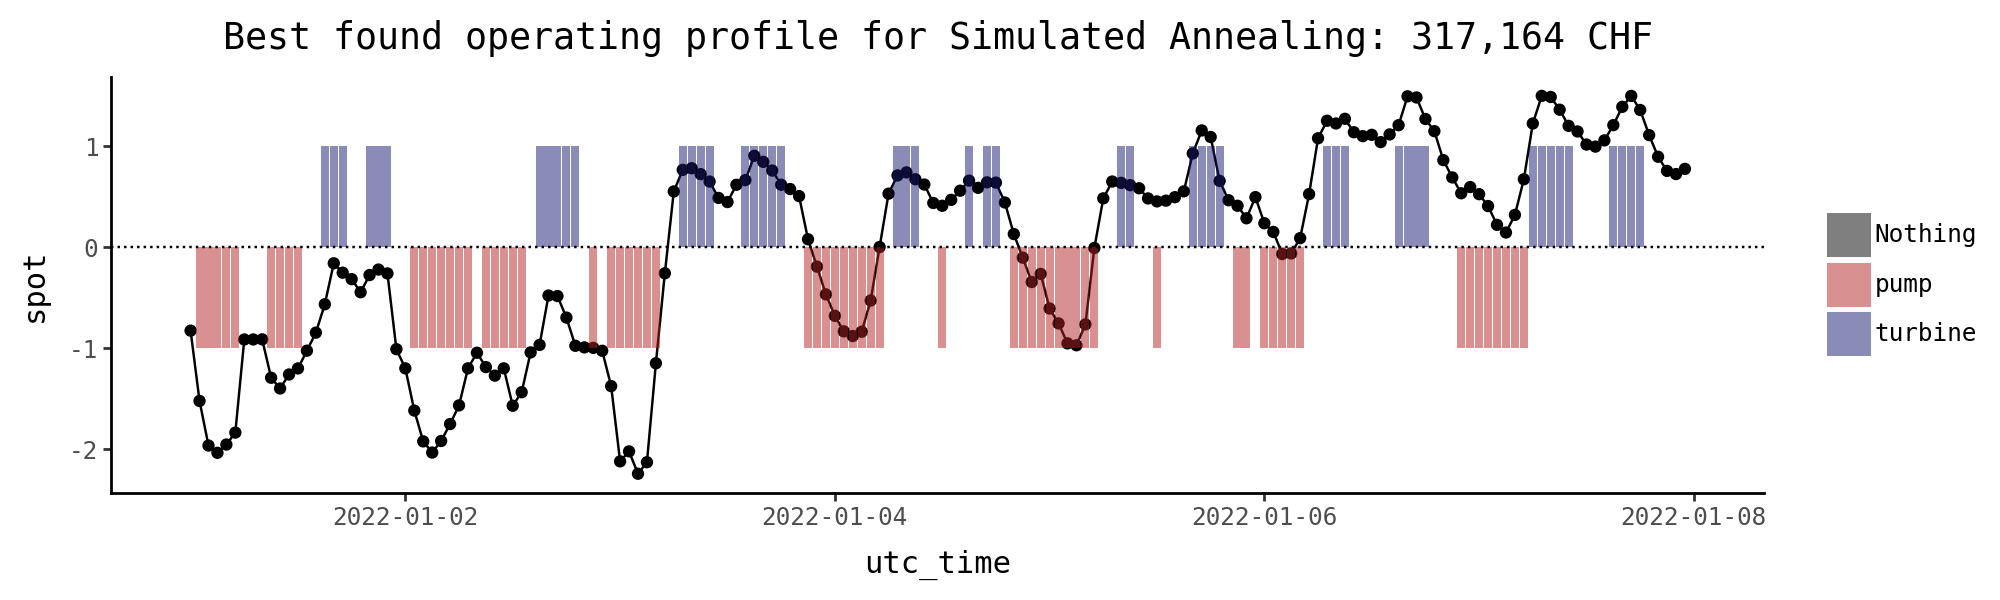

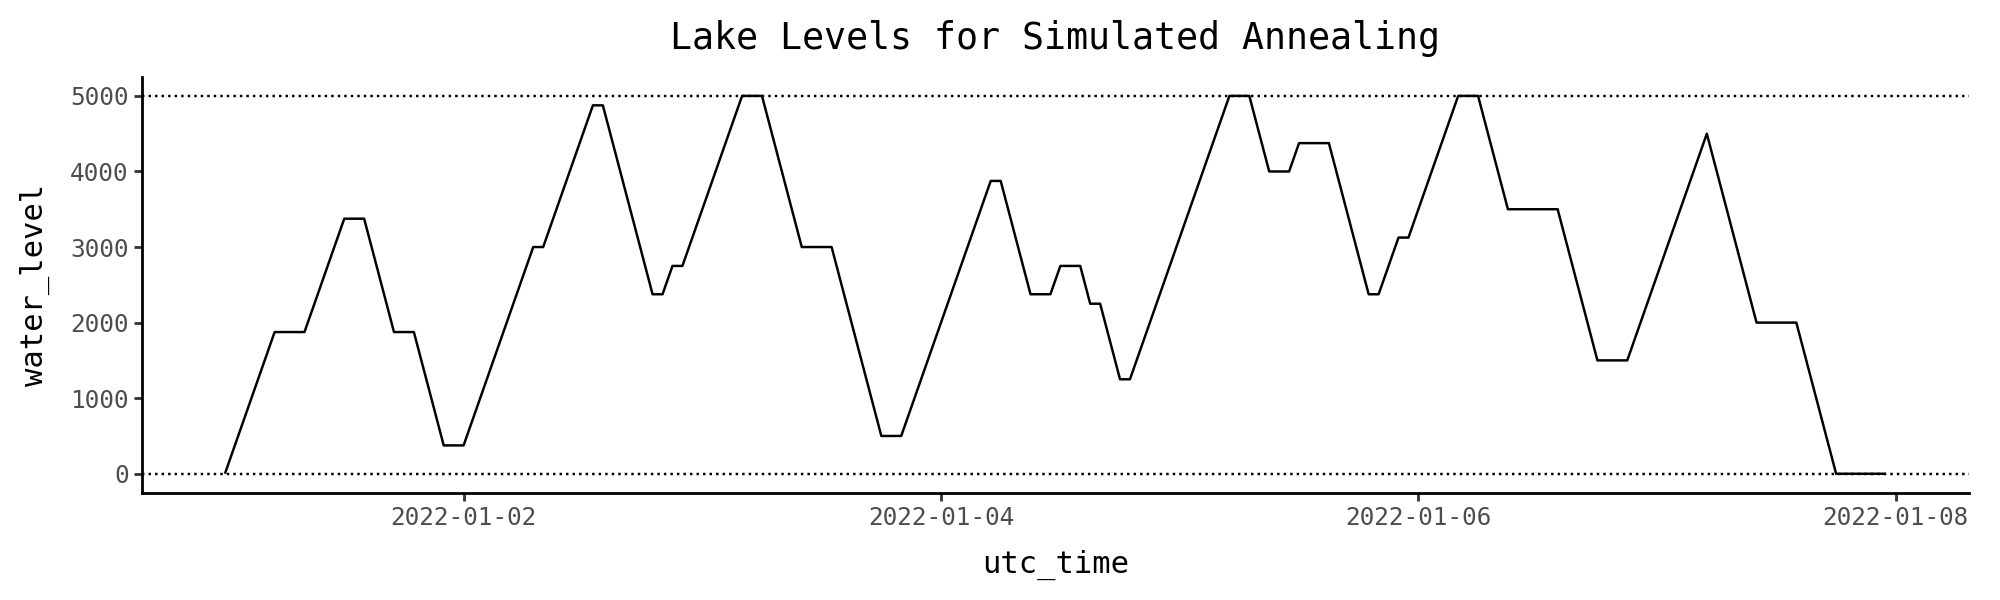

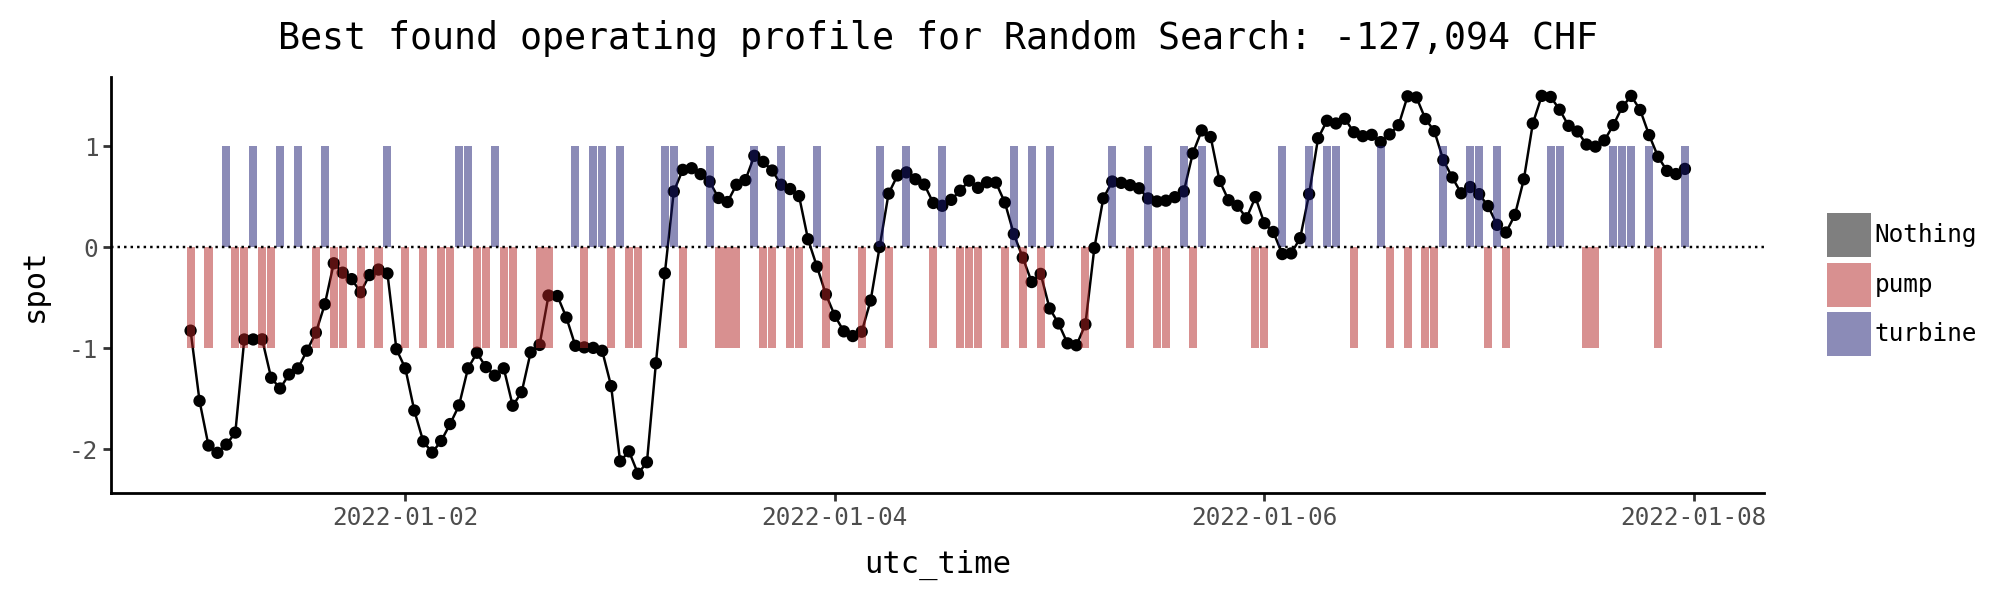

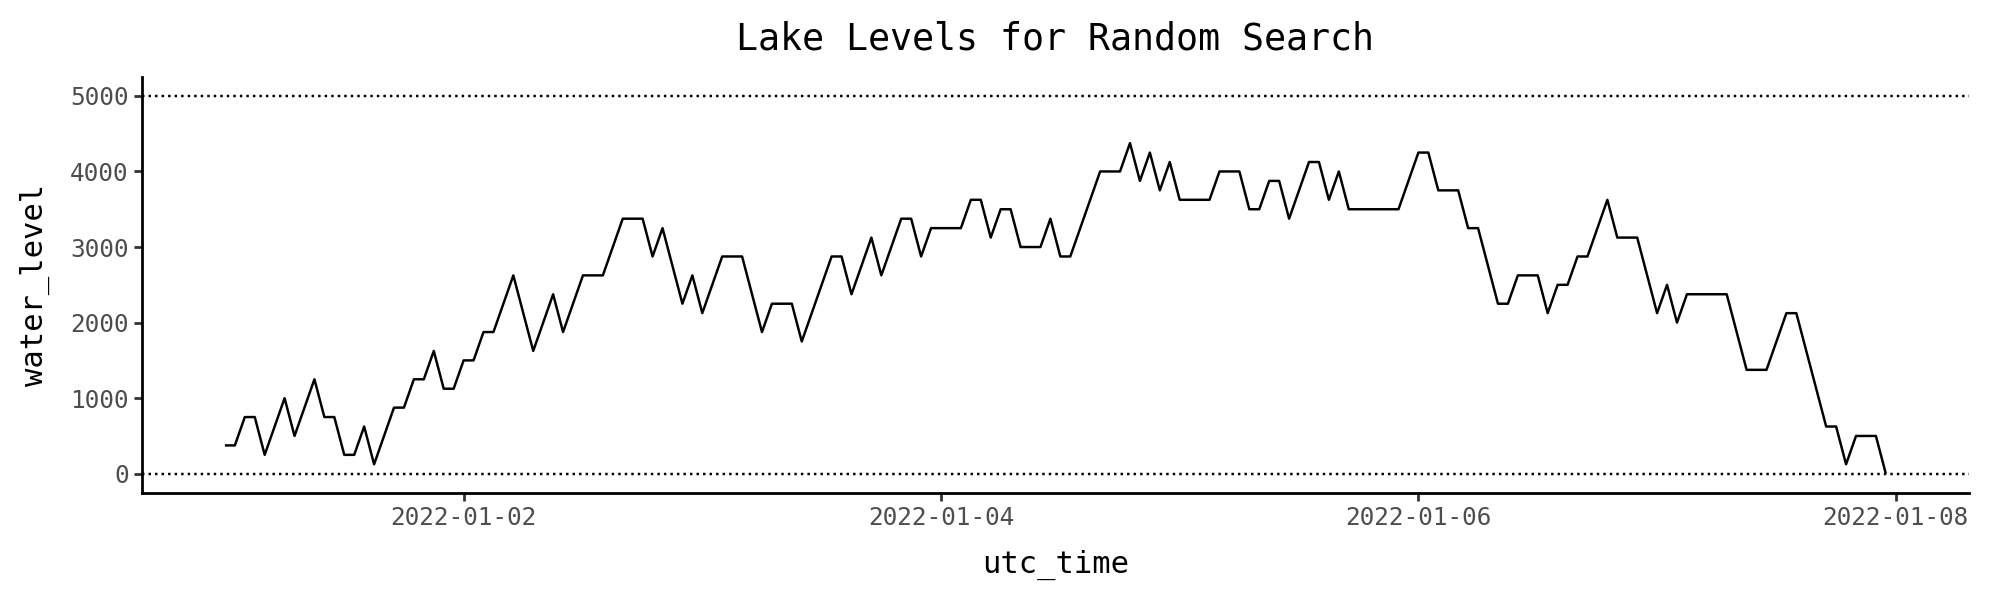

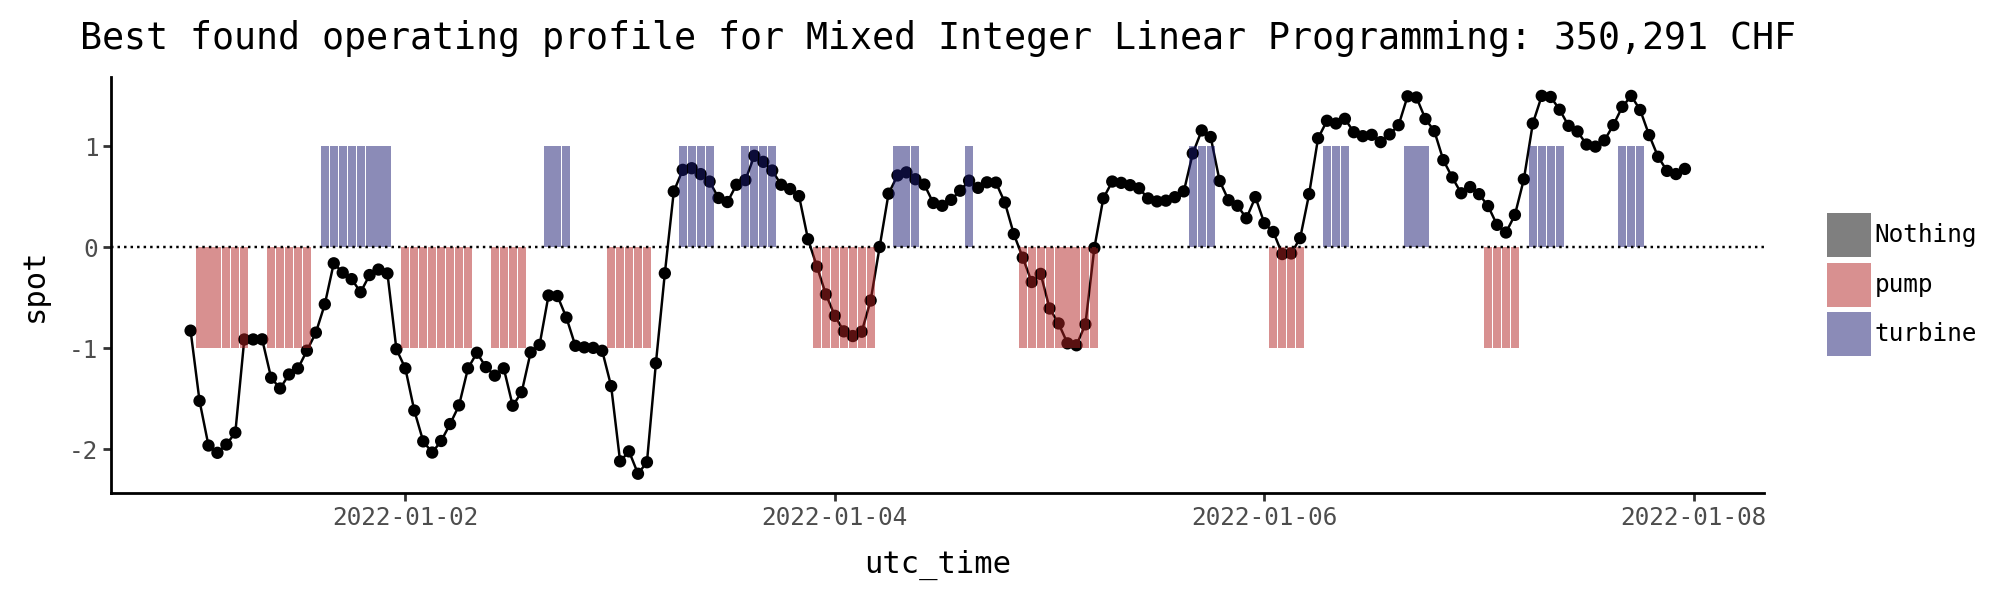

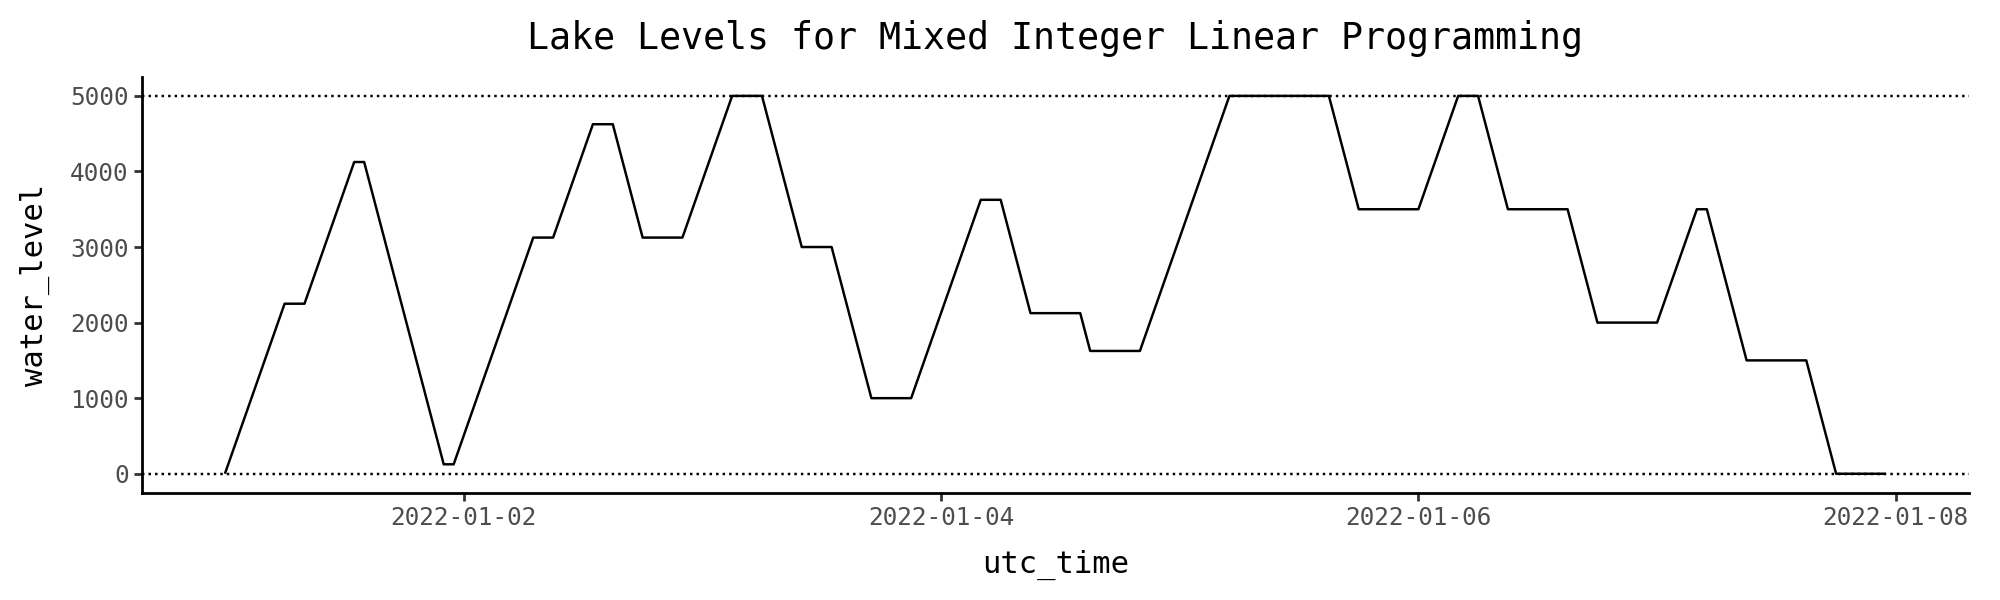

In [72]:
algos = ["ga_action", "sa_action", "bf_action", "milp_action"]
algo_names = ["Genetic Algorithm", "Simulated Annealing", "Random Search", "Mixed Integer Linear Programming"]

for idx, algo in enumerate(algos):

    best_profile = (
        actions.select("utc_time", "spot", algo)
        .rename({algo: "action"})
        .with_columns(
            colour_id=pl.when(pl.col("action") == -1)
            .then(pl.lit("pump"))
            .when(pl.col("action") == 1)
            .then(pl.lit("turbine"))
            .otherwise(pl.lit("Nothing"))
        )
        .with_columns(
            water_level=plant_params["INITIAL_WATER_LEVEL_PCT"]
            + (
                pl.when(pl.col("action") == -1)
                .then(plant_params["PUMP_RATE_M3H"])
                .when(pl.col("action") == 1)
                .then(-plant_params["TURBINE_RATE_M3H"])
                .otherwise(0)
                .cum_sum()
            )
        )
        .to_pandas()
        .sort_values("utc_time")
    )

    best_profit = profit(actions=best_profile["action"], prices=example, ps_params=plant_params)

    # Operating Profile
    fig = (
        pn.ggplot(
            data=best_profile.assign(
                spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std()
            ),
            mapping=pn.aes(x="utc_time"),
        )
        + pn.geom_line(pn.aes(y="spot"))
        + pn.geom_point(pn.aes(y="spot"))
        + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.5)
        + pn.labs(title=f"Best found operating profile for {algo_names[idx]}: {best_profit:,.0f} CHF")
        + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
        + pn.geom_hline(yintercept=0, linetype="dotted")
        # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
        + pn.theme(figure_size=[10, 3], legend_title=pn.element_blank())
    )
    display(fig)

    # Lake level
    fig = (
        pn.ggplot(data=best_profile, mapping=pn.aes(x="utc_time", y="water_level"))
            + pn.geom_line()
            + pn.labs(title=f"Lake Levels for {algo_names[idx]}")
            + pn.geom_hline(yintercept=plant_params["MAX_STORAGE_M3"], linetype="dotted")
            + pn.geom_hline(yintercept=plant_params["MIN_STORAGE_M3"], linetype="dotted")
            # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
            # + pn.coord_cartesian(ylim=[0, best_profile.water_level.max()*1.1])
            + pn.theme(figure_size=[10, 3], legend_title=pn.element_blank())
        )
    display(fig)
    

We can see in the charts above that MILP had the best performance out of all methods, which is not surprising as it is expected to find the global optimum. The genetic algorithm performed second best and simulated annealing performed worst out of these three. However, both heuristic algorithms beat the brute force benchmark by a considerable margin and worked incredibly well in my opinion. It is interesting to see that single hours could be shifted left and right in both heuristic methods, indicating that my exploration methods might not have been optimal. For instance, it might have been a good idea to include a randomised exploration strategy of changing actions (like I did) and swapping hours (which I have not implemented). Maybe then, the optimum might have been found.

If you made it this far, thank you very much for reading and feel free to reach out for further information or collaboration on a project.

# Animation

This section of the blog is past the end and contains the code that created the animated GIF at the start of the blog and has no description or explanation.

## Static Plot Generation

### GA All Fitnesses

In [134]:
# | eval: false

with open("./03 - Final Run Results/ga_all_fitnesses.npy", "rb") as f:
    ga_all_fitnesses = np.load(f)

np.random.seed(1)
ga_all_fitnesses_df = (
    pl.DataFrame(
        ga_all_fitnesses, schema=[f"{i}" for i in range(ga_all_fitnesses.shape[0])]
    )
    .unpivot(variable_name="generation")
    .with_columns(pl.col("generation").cast(pl.Int64))
    .sample(fraction=1)
)

In [135]:
#| eval: false

# warnings.filterwarnings('ignore')
plot_data = None

for idx in tqdm(range(ga_all_fitnesses.shape[0])):

    # Filter data
    plot_data = (
        pl.DataFrame(
            ga_all_fitnesses, schema=[f"{i}" for i in range(ga_all_fitnesses.shape[0])]
        )
        .unpivot(variable_name="generation")
        .with_columns(pl.col("generation").cast(pl.Int64))
        .filter(
            (pl.col("generation") <= idx) 
            # & (pl.col("generation") >= idx - 50)
        )
        .with_columns(
            # shading=((pl.col("generation") + 1) / (idx + 1)) ** 1e600
            shading=pl.when(pl.col("generation") == idx).then(pl.lit(1)).otherwise(pl.lit(0.01))
        )

    )
    # print(plot_data)

    # Plot data
    fig = (
        pn.ggplot(
            data=plot_data.group_by("generation").head(50),
            mapping=pn.aes(x="generation", y="value"),
        )
        + pn.geom_point(pn.aes(alpha="shading"))
        + pn.labs(title=f"Genetic Algorithm: Generation {idx}",
                  y = "profit", x = "generation")
        + pn.scale_x_continuous(limits=(0, ga_all_fitnesses.shape[0]))
        + pn.scale_y_continuous(
            labels=comma_format(), limits=[-4e5, 4e5]
        )
        # + pn.theme_light()
        + pn.theme(
            figure_size=[5, 5 * ((5/3) / (4/2))], legend_title=pn.element_blank(), 
            legend_position="none"
        )
    )
    fig.save(filename = f"./04 - Animation/GA_fitnesses/generation_{idx:03d}", height=5 * ((5/3) / (4/2)), width=5, dpi=300)
    # display(fig)
    # clear_output(wait=True)
    # break

  0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/GA_fitnesses/generation_000
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 49 rows containing missing values.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/GA_fitnesses/generation_001
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 99 rows containing missing values.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166

### SA All Fitnesses

In [159]:
with open("./03 - Final Run Results/sa_all_profits.npy", "rb") as f:
    sa_all_profits = np.load(f)

Reduce to 1000 frames to keep the folder manageable:

In [160]:
max_frames = 1000
plot_data = (
    pl.DataFrame(pl.Series(values=sa_all_profits, name="profit")).with_columns(pl.Series(np.arange(0, len(sa_all_profits))).alias("iteration"))
    .with_columns(((pl.col("iteration") / len(sa_all_profits)) * max_frames).floor().alias("frame"))
    .group_by("frame")
    .tail(1)
    .sort("frame")
)
print(plot_data.shape)
plot_data.head()


(1000, 3)


frame,profit,iteration
f64,f64,i32
0.0,-1.195824e6,74
1.0,-1.106363e6,149
2.0,-63354.0,224
3.0,9623.0,299
4.0,35701.0,374


In [161]:
#| eval: false

for idx in tqdm(range(max_frames)):

    # Plot data
    fig = (
        pn.ggplot(
            data=plot_data.filter(pl.col("frame") <= idx),
            mapping=pn.aes(x="iteration", y="profit"),
        )
        + pn.geom_line()
        + pn.labs(
            title=f"Simulated Annealing: Iteration {plot_data.filter(pl.col('frame') == idx)['iteration'][0]}",
            y="profit",
            x="iteration",
        )
        + pn.scale_x_continuous(
            labels=comma_format(), limits=(0, plot_data["iteration"].max())
        )
        + pn.scale_y_continuous(labels=comma_format())
        + pn.coord_cartesian(
            ylim=[
                plot_data.filter(pl.col("frame") <= idx).tail(500)["profit"].min(),
                plot_data.filter(pl.col("frame") <= idx).tail(500)["profit"].max(),
            ]
        )
        + pn.theme(
            figure_size=[5, 5 * ((5/3) / (4/2))], legend_title=pn.element_blank(), legend_position="none"
        )
    )
    fig.save(filename = f"./04 - Animation/SA_fitnesses/iteration_{idx:04d}", height=5 * ((5/3) / (4/2)), width=5, dpi=300)
    # display(fig)
    # clear_output(wait=True)
    # break

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/SA_fitnesses/iteration_0000
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/SA_fitnesses/iteration_0001
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:60

### GA Profiles

In [139]:
with open("./03 - Final Run Results/ga_actions.npy", "rb") as f:
    ga_actions = np.load(f)

In [140]:
#| eval: false

for idx in tqdm(range(ga_actions.shape[0])):

    plot_data = (
        example.select("utc_time", "spot")
        .with_columns(action = pl.Series(ga_actions[idx]))
        .with_columns(
            colour_id=pl.when(pl.col("action") == -1)
            .then(pl.lit("pump"))
            .when(pl.col("action") == 1)
            .then(pl.lit("turbine"))
            .otherwise(pl.lit("Nothing"))
        )
        .with_columns(
            water_level=plant_params["INITIAL_WATER_LEVEL_PCT"]
            + (
                pl.when(pl.col("action") == -1)
                .then(plant_params["PUMP_RATE_M3H"])
                .when(pl.col("action") == 1)
                .then(-plant_params["TURBINE_RATE_M3H"])
                .otherwise(0)
                .cum_sum()
            )
        )
        .to_pandas()
        .sort_values("utc_time")
    )
    
    # Operating Profile
    fig = (
        pn.ggplot(
            data=plot_data.assign(
                spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std()
            ),
            mapping=pn.aes(x="utc_time"),
        )
        + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.6)
        + pn.geom_line(pn.aes(y="spot"))
        + pn.geom_point(pn.aes(y="spot"))
        + pn.labs(title=f"Profile At Generation {idx}", x = "Time", y="Spot Price and Action")
        + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
        + pn.geom_hline(yintercept=0, linetype="dotted")
        # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
        + pn.theme(
            figure_size=[5, 5 * ((5/3) / (4/2))],
            legend_title=pn.element_blank(),
            legend_position="none",
        )
    )
    fig.save(filename = f"./04 - Animation/GA_profiles/generation_{idx:04d}", height=5 * ((5/3) / (4/2)), width=5, dpi=300)
    # display(fig)
    # clear_output(wait=True)
    # break

  0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/GA_profiles/generation_0000
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/GA_profiles/generation_0001
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/GA_profiles/generation_0002
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in 

### SA Profiles

In [141]:
with open("./03 - Final Run Results/sa_actions.npy", "rb") as f:
    sa_actions = np.load(f)

In [142]:
max_frames = 1000
frames = [i for i in range(len(sa_actions)) if i % int(len(sa_actions)/max_frames) == 0]

In [143]:
#| eval: false

for idx in tqdm(range(max_frames)):

    plot_data = (
        example.select("utc_time", "spot")
        .with_columns(action=pl.Series(sa_actions[frames[idx]]))
        .with_columns(
            colour_id=pl.when(pl.col("action") == -1)
            .then(pl.lit("pump"))
            .when(pl.col("action") == 1)
            .then(pl.lit("turbine"))
            .otherwise(pl.lit("Nothing"))
        )
        .with_columns(
            water_level=plant_params["INITIAL_WATER_LEVEL_PCT"]
            + (
                pl.when(pl.col("action") == -1)
                .then(plant_params["PUMP_RATE_M3H"])
                .when(pl.col("action") == 1)
                .then(-plant_params["TURBINE_RATE_M3H"])
                .otherwise(0)
                .cum_sum()
            )
        )
        .to_pandas()
        .sort_values("utc_time")
    )

    # Operating Profile
    fig = (
        pn.ggplot(
            data=plot_data.assign(
                spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std()
            ),
            mapping=pn.aes(x="utc_time"),
        )
        + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.6)
        + pn.geom_line(pn.aes(y="spot"))
        + pn.geom_point(pn.aes(y="spot"))
        + pn.labs(
            title=f"Profile At Iteration {frames[idx]}", x="Time", y="Spot Price and Action"
        )
        + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
        + pn.geom_hline(yintercept=0, linetype="dotted")
        # + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
        + pn.theme(
            figure_size=[5, 5 * ((5/3) / (4/2))],
            legend_title=pn.element_blank(),
            legend_position="none",
        )
    )
    fig.save(filename = f"./04 - Animation/SA_profiles/generation_{idx:04d}", height=5 * ((5/3) / (4/2)), width=5, dpi=300)
    # display(fig)
    # clear_output(wait=True)
    # break

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/SA_profiles/generation_0000
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/SA_profiles/generation_0001
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/SA_profiles/generation_0002
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 5 x 4.166666666666667 in 

### Best Profits

In [144]:
with open("./03 - Final Run Results/ga_best_fitnesses.npy", "rb") as f:
    ga_profits = np.load(f)

In [145]:
with open("./03 - Final Run Results/sa_best_profits.npy", "rb") as f:
    sa_profits = np.load(f)

In [146]:
with open("./03 - Final Run Results/bf_best_profits.npy", "rb") as f:
    bf_profits = np.load(f)

In [147]:
len(ga_profits)

250

In [148]:
len(sa_profits)

75000

In [149]:
len(bf_profits)

150000

In [150]:
max_frames = len(ga_profits)
sa_frames = [i-1 for i in range(1, len(sa_profits) + 1) if i % int(len(sa_profits)/max_frames) == 0]
bf_frames = [i-1 for i in range(1, len(bf_profits) + 1) if i % int(len(bf_profits)/max_frames) == 0]

In [151]:
plot_data = pl.DataFrame(
    {
        "generation": np.arange(0, len(ga_profits)),
        "Genetic Algorithm": ga_profits,
        "Simulated Annealing": sa_profits[sa_frames],
        "Brute Force Random Search": bf_profits[bf_frames],
    }
).unpivot(index="generation")
plot_data.head()

generation,variable,value
i32,str,f64
0,"""Genetic Algorithm""",-177561.0
1,"""Genetic Algorithm""",-19350.0
2,"""Genetic Algorithm""",-12588.0
3,"""Genetic Algorithm""",-12588.0
4,"""Genetic Algorithm""",23985.0


In [152]:

#| eval: false
for idx in tqdm(range(plot_data["generation"].unique().shape[0])):
    # Operating Profile
    fig = (
        pn.ggplot(
            data=plot_data.filter(pl.col("generation") <= idx),
            mapping=pn.aes(x="generation", y="value", colour="variable"),
        )
        + pn.geom_line(size=0.8)
        + pn.labs(y = "Best Profit", x="Time (30 seconds)")
        + pn.scale_x_continuous(limits=[0, plot_data["generation"].max()])
        + pn.scale_y_continuous(labels=comma_format())
        + pn.coord_cartesian(
            ylim=[
                plot_data.filter(pl.col("generation") <= idx).tail(20)["value"].min(),
                plot_data["value"].max(),
            ]
        )
        # + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
        + pn.theme(
            figure_size=[7, 7 * ((4/3) / 4)],
            legend_title=pn.element_blank(),
            axis_text_x=pn.element_blank(),
            # legend_position="none",
        )
    )
    fig.save(filename = f"./04 - Animation/Profits/generation_{idx:03d}", height=7 * ((4/3) / 4), width=7, dpi=300)
    # display(fig)
    # clear_output(wait=True)
    # break

  0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 2.333333333333333 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/Profits/generation_000
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\geoms\geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 2.333333333333333 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ./04 - Animation/Profits/generation_001
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 2.333333333333333 in image.
c:\Users\mathi\miniconda3\envs\general\Lib\site-packages\plotnine\ggplot.py:607: Plotnin

## Video Generation

I will create videos from the raw plots and later edit them together in a video editing program manually for the final animation.

In [153]:
def generate_video(image_path, video_path, fps):
    
    # Get list of PNG files sorted
    file_names = sorted([f for f in os.listdir(image_path) if f.endswith('.png')])

    writer = imageio.get_writer(video_path, fps=fps)
    # Read PNG files and append to images list
    for file_name in file_names:
        file_path = os.path.join(image_path, file_name)
        im = imageio.v2.imread(file_path)
        writer.append_data(im)

    writer.close()

### GA All profits

In [154]:
# | eval: false
generate_video(
    image_path="./04 - Animation/GA_fitnesses/",
    video_path="./04 - Animation/ga_fitnesses.mp4",
    fps=15
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1250) to (1504, 1264) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### SA All Profits

In [162]:
# | eval: false
generate_video(
    image_path="./04 - Animation/SA_fitnesses/",
    video_path="./04 - Animation/sa_fitnesses.mp4",
    fps=60
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1250) to (1504, 1264) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### GA Profiles

In [156]:
# | eval: false
generate_video(
    image_path="./04 - Animation/GA_profiles/",
    video_path="./04 - Animation/ga_profiles.mp4",
    fps=15
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1250) to (1504, 1264) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### SA Profiles

In [157]:
# | eval: false
generate_video(
    image_path="./04 - Animation/SA_profiles/",
    video_path="./04 - Animation/sa_profiles.mp4",
    fps=60
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1250) to (1504, 1264) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Best Profits

In [158]:
# | eval: false
generate_video(
    image_path="./04 - Animation/Profits/",
    video_path="./04 - Animation/best_profits.mp4",
    fps=15
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2100, 699) to (2112, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
